# Sliding Window Combined with CNN for Bamboo forest detection

# Introduction
We will detect bamboo forest without using specialized  networks like U-net, but with a general CNN for classification, we still can perform a segmentation. The concept originates from the "Patch-based Classification", proposed in the following paper. We will combine a sliding window patches with repetitive CNN classification which allows detection of tumor region(s).

Watanabe et al., performed a similar approach to segment bamboo forests from satelite images retreived from google earth. They express their method as "chopped images", however paying respect to the previous research, I describe this method as "Patch-based Classification". 


**Deep Learning for Identifying Metastatic Breast Cancer**

https://arxiv.org/abs/1606.05718
![image](https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/assets/cancer.png)




# 1. Import Libraries

In [1]:
#!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
#from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


# 2. Load dataset

In [2]:
!ls

README.md                           bamboo_forest_detection.html
bamboo_forest_detection-Copy1.ipynb bamboo_forest_detection.ipynb


In [4]:
## Download and extract dataset
#!wget https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip bamboo.zip
!curl https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip -o bamboo.zip
!unzip -P bamboo bamboo.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26.9M  100 26.9M    0     0  1035k      0  0:00:26  0:00:26 --:--:-- 1083k
Archive:  bamboo.zip
   creating: bamboo/
   creating: bamboo/test/
  inflating: bamboo/test/test_image.png  
   creating: bamboo/train/
  inflating: bamboo/train/b1.png     
  inflating: bamboo/train/o4.png     
  inflating: bamboo/train/b13.png    
  inflating: bamboo/train/b5.png     
  inflating: bamboo/train/b8.png     
  inflating: bamboo/train/b11.png    
  inflating: bamboo/train/b9.png     
  inflating: bamboo/train/o10.png    
  inflating: bamboo/train/b4.png     
  inflating: bamboo/train/o1.png     
  inflating: bamboo/train/o6.png     
  inflating: bamboo/train/o7.png     
  inflating: bamboo/train/b6.png     
  inflating: bamboo/train/b3.png     
  inflating: bamboo/train/o2.png     
  inflating: bamboo/train/o5.png     
  inflating: bambo

# 3. Data Visualization

In [5]:
!ls bamboo/train
#image names starting with "b" is image with only bamboo forest.
#image names starting with "o" is image without bamboo forest.

b1.png  b12.png b2.png  b5.png  b8.png  o10.png o4.png  o7.png
b10.png b13.png b3.png  b6.png  b9.png  o2.png  o5.png  o8.png
b11.png b14.png b4.png  b7.png  o1.png  o3.png  o6.png  o9.png


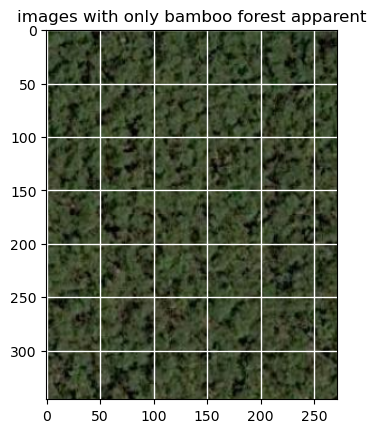

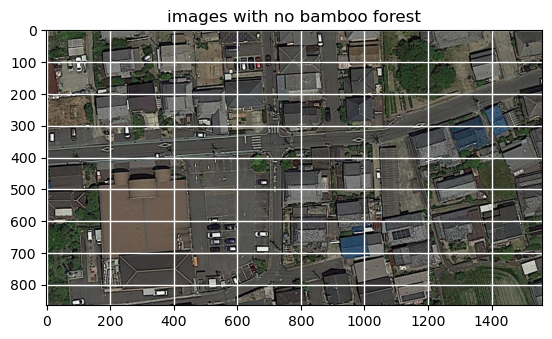

In [9]:
plt.title("images with only bamboo forest apparent")
ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=1)
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=1)
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


## Helper function for creating `patches` from each image using a sliding window

In [10]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("bamboo/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "bamboo/chopped"
    file = os.path.join("bamboo/train/",file)
    save_to_folder(file,save_directory)

In [11]:
files = os.listdir("bamboo/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("bamboo/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(3492, 56, 56, 3) (3492,)


# 4. Modelling

## Data Preparation

In [12]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(2793, 56, 56, 3)
(2793,)
(699, 56, 56, 3)
(699,)


In [14]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight(class_weight = "balanced", classes = np.unique(train_y), y = train_y)
print(cw)

(array([0, 1]), array([ 700, 2093]))
(array([0, 1]), array([175, 524]))
[1.995      0.66722408]


## Build and Train CNN

In [15]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 56, 56, 16)        448       
                                                                 
 pool1 (MaxPooling2D)        (None, 28, 28, 16)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 32)        4640      
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

In [17]:
cw_dict = {l:c for l,c in zip(np.unique(train_y), cw)}
history = model.fit(train_x,train_y,epochs=10,validation_data=(valid_x,valid_y),class_weight=cw_dict)

Epoch 1/10


2023-11-26 21:57:55.634170: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


88/88 [==============================] - 2s 17ms/step - loss: 0.4309 - acc: 0.8127 - val_loss: 0.2818 - val_acc: 0.8541
Epoch 2/10
88/88 [==============================] - 1s 14ms/step - loss: 0.1667 - acc: 0.9449 - val_loss: 0.1179 - val_acc: 0.9700
Epoch 3/10
88/88 [==============================] - 1s 14ms/step - loss: 0.1474 - acc: 0.9585 - val_loss: 0.1233 - val_acc: 0.9843
Epoch 4/10
88/88 [==============================] - 1s 15ms/step - loss: 0.1338 - acc: 0.9631 - val_loss: 0.1442 - val_acc: 0.9599
Epoch 5/10
88/88 [==============================] - 1s 15ms/step - loss: 0.1867 - acc: 0.9373 - val_loss: 0.1149 - val_acc: 0.9628
Epoch 6/10
88/88 [==============================] - 1s 14ms/step - loss: 0.1037 - acc: 0.9749 - val_loss: 0.1624 - val_acc: 0.9428
Epoch 7/10
88/88 [==============================] - 1s 15ms/step - loss: 0.1147 - acc: 0.9685 - val_loss: 0.0718 - val_acc: 0.9857
Epoch 8/10
88/88 [==============================] - 1s 15ms/step - loss: 0.0809 - acc: 0.9778 

## Evaluation

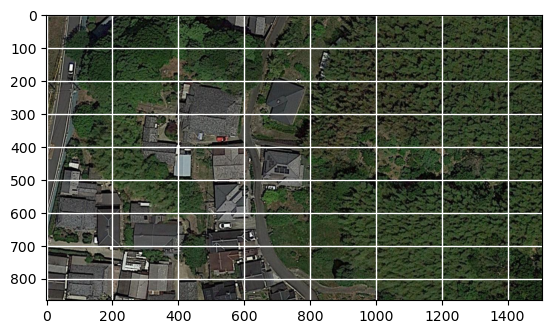

37
2405 37 65


In [19]:
#read test data
img_path = "bamboo/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=1)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

## Prediction

76/76 [==============================] - 0s 4ms/step
(2405, 1)
[[7.0978695e-01]
 [6.3132876e-01]
 [7.1451128e-01]
 ...
 [6.2021182e-04]
 [1.5718531e-03]
 [2.3603397e-03]]


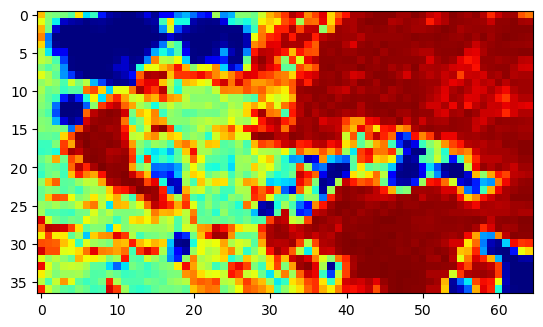

In [20]:
#predict the bamboo probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

bamboo = np.reshape(predictions,(n_total//n_x,n_x))
bamboo = np.rot90(bamboo)
bamboo = np.flip(bamboo,axis=0)
plt.imshow(bamboo,cmap="jet")

note that each images correspond to 1 pixel of probability, and the size is not compatible with the input images.
we will caculate the ratio factor and resize it.

In [21]:
h_factor = img.shape[0]//bamboo.shape[0]
w_factor = img.shape[1]//bamboo.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(bamboo,(h_factor,w_factor))

print(zoomed.shape)

23
(851, 1495)


### Zooming Prediction

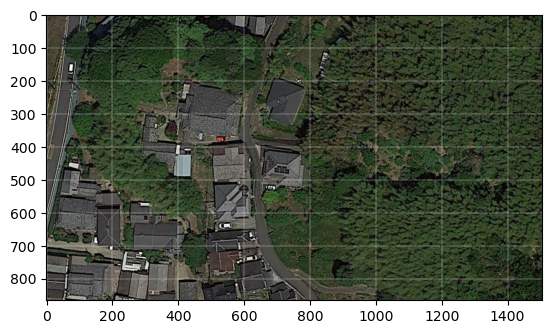

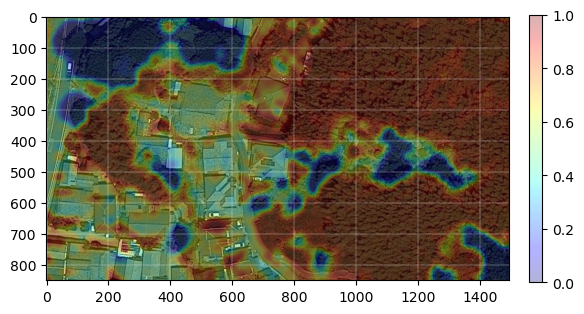

In [24]:
#result
plt.imshow(img)
ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=0.2)
plt.show()

plt.imshow(img)
ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=0.2)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

# Reference

Original Article
**Using deep learning for bamboo forest detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643